<a href="https://colab.research.google.com/github/sharat-shankar/NLP_J045/blob/master/Automated_Essay_Grading_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 84kB/s 
     |████████████████████████████████| 491kB 41.8MB/s 
     |████████████████████████████████| 3.2MB 32.8MB/s 
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


In [0]:
#Library Requirements
import os
import re
import nltk
import scipy
import gensim
import pickle 
import itertools
import numpy as np
import pandas as pd
import keras.backend as K
from gensim import models
from google.colab import files
from nltk.corpus import stopwords
from itertools import combinations
from sklearn.pipeline import Pipeline
from string import digits,punctuation 
from nltk.tokenize import word_tokenize
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split as tts
from keras.models import Sequential, load_model, model_from_config
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
nltk.download('punkt')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords') 
nltk.download('averaged_perceptron_tagger')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
! wget https://raw.githubusercontent.com/sharat-shankar/NLP_J045/master/ASAP_AES_DATA/training_set_rel3.tsv

--2020-04-06 16:17:56--  https://raw.githubusercontent.com/sharat-shankar/NLP_J045/master/ASAP_AES_DATA/training_set_rel3.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16337165 (16M) [text/plain]
Saving to: ‘training_set_rel3.tsv’

training_set_rel3.t 100%[===================>]  15.58M  --.-KB/s    in 0.1s    

2020-04-06 16:17:56 (119 MB/s) - ‘training_set_rel3.tsv’ saved [16337165/16337165]



In [0]:
df = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')
y = df['domain1_score']
X = df.dropna(axis=1)
X = X.drop(columns=['domain1_score', 'rater1_domain1', 'rater2_domain1'])
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

In [0]:
# Function to extract tokens from the body and remove stopwords, punctuations and digits
remove_digits = str.maketrans('', '', digits)
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

def token_extractifier(str):
  str = str.lower()
  str = str.translate(remove_digits)
  str = re.sub(r'[^\w\s]',' ',str)
  token = word_tokenize(str)
  words = [word for word in token if word not in stop_words and word not in punctuation]
  return words

def tokenized_df(df):
   df = df.apply(token_extractifier)
   return df

In [0]:
# Fuction to convert the processed doc into Count Vectorizer dataframe
def dummy_function(doc):
    return doc

def convert_to_count_vec(df):
  global vectorizer
  global vectors
  vectorizer = CountVectorizer(analyzer='word',tokenizer=dummy_function,preprocessor=dummy_function,token_pattern=None)
  vectors = vectorizer.fit_transform(df)
  filename = '/content/drive/My Drive/finalized_model.sav'
  pickle.dump(vectorizer, open(filename, 'wb'))
  return vectors

In [0]:
# Function to get the LSTM model
def df_modifier(df):
    data = pd.DataFrame((df.todense()).tolist(),columns = vectorizer.get_feature_names())
    data = np.array(data)
    data = np.reshape(data, (data.shape[0], 1, data.shape[1]))
    return data

def lstm_model(df):
    """Define the model."""
    df = df_modifier(df)
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, df.shape[2]], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.fit(df, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.25)
    model.save('/content/drive/My Drive/lstm.h5')

    return model

In [0]:
# Fuction to convert the processed doc into Count Vectorizer dataframe
def test_to_count_vec(df):
    filename = '/content/drive/My Drive/finalized_model.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    vectors = loaded_model.transform(df)
    return vectors

In [0]:
def lstm_predictions(df):
  ls_model = load_model('/content/drive/My Drive/lstm.h5')
  df = df_modifier(df)
  preds = ls_model.predict(df)
  preds = np.around(preds)
  return preds

In [0]:
# Training and Saving the model.
train_data = tokenized_df(X_train['essay'])
train_data = convert_to_count_vec(train_data)
LSTM_model = lstm_model(train_data)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 7785 samples, validate on 2595 samples
Epoch 1/10
7785/7785 [==============================] - 167s 21ms/step - loss: 54.3802 - mean_absolute_error: 3.3775 - val_loss: 38.7942 - val_mean_absolute_error: 2.5578
Epoch 2/10
7785/7785 [==============================] - 163s 21ms/step - loss: 32.9819 - mean_absolute_error: 2.4167 - val_loss: 25.5753 - val_mean_absolute_error: 2.0666
Epoch 3/10
7785/7785 [==============================] - 167s 21ms/step - loss: 21.8425 - mean_absolute_error: 1.9764 - val_loss: 16.8560 - val_mean_absolute_error: 1.7408
Epoch 4/10
7785/7785 [==============================] - 162s 21ms/step - loss: 14.1494 - mean_absolute_error: 1.6823 - val_loss: 10.6658 - val_mean_absolute_error: 1.4499
Epoch 5/10
7785/7785 [==============================]

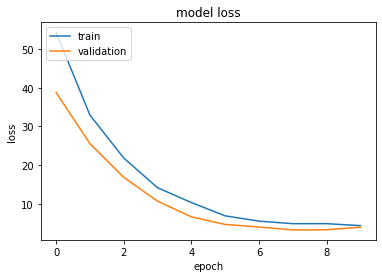

In [0]:
import matplotlib.pyplot as plt
history = LSTM_model.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
# Testing the model on UNSEEN Data.
test_data = tokenized_df(X_test['essay'])
test_data = test_to_count_vec(test_data)
y_pred = lstm_predictions(test_data)

In [0]:
print("Cohen Kappa Score: {}".format(cohen_kappa_score(y_test.values,y_pred,weights='quadratic')))

Cohen Kappa Score: 0.9705870891094559


In [0]:
model_json = LSTM_model.to_json()
with open('/content/drive/My Drive/grader_lstm_model.json','w') as json_file:
  json_file.write(model_json)

In [0]:
LSTM_model.save_weights('/content/drive/My Drive/grader_lstm_model_weights.h5')